# Customer Churn Project — Part 3: Baseline Logistic Regression

This notebook is the starting point for the Customer Churn Analysis Project. Its primary goals are to ingest, explore, clean, and augment the customer activity logs to build a robust dataset for understanding user behavior and churn.

Specifically, in this notebook, I:
1. Conduct exploratory data analysis (EDA) to compare active vs. churned users across engagement metrics.
2. Examine event distributions, feature correlations, and behavioral indicators leading to churn.
3. Analyze temporal and geographic churn trends to understand how churn varies across months and states.
4. Identify early behavioral signals (e.g., low activity, fewer playlists, short active periods) that differentiate churned users.
5. Prepare analytical insights to inform predictive modeling and feature selection in the next stage (03_Modeling.ipynb).

The focus of this notebook is on uncovering data-driven insights about customer retention and disengagement, laying the foundation for building a churn prediction model and actionable business recommendations.

In [2]:
import json
import pandas as pd
import numpy as np
import os
from pyspark.sql.window import Window
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import pandas as pd

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline


sns.set(style="whitegrid", palette="muted", font_scale=1.1)

In [11]:
os.environ["JAVA_HOME"] = "/Library/Java/JavaVirtualMachines/openjdk-17.jdk/Contents/Home"

try:
    spark.stop()
except:
    pass


spark = (
    SparkSession.builder
    .appName("CustomerChurn_EDA")
    .master("local[*]")
    .config("spark.driver.memory", "6g")  
    .config("spark.sql.shuffle.partitions", "8")
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")
    .getOrCreate()
)
spark.sparkContext.setLogLevel("ERROR")
#print("✅ Spark started:", spark.version)

25/10/14 13:04:22 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [13]:
data = spark.read.parquet("../data/churn_data_ready.parquet")

In [14]:
user_features = (
    data.groupBy("userId")
    .agg(
        F.first("churn_flag").alias("churn_flag"),
        F.countDistinct("sessionId").alias("num_sessions"),
        F.sum(F.when(F.col("page") == "NextSong", 1).otherwise(0)).alias("num_songs"),
        F.sum(F.when(F.col("page") == "Thumbs Up", 1).otherwise(0)).alias("thumbs_up"),
        F.sum(F.when(F.col("page") == "Thumbs Down", 1).otherwise(0)).alias("thumbs_down"),
        F.sum(F.when(F.col("page") == "Add to Playlist", 1).otherwise(0)).alias("add_playlist"),
        ( (F.max("ts") - F.min("ts")) / (1000 * 60 * 60 * 24) ).alias("active_days")
    )
)

In [15]:
user_features.head(10)

[Row(userId='1567623', churn_flag=0, num_sessions=16, num_songs=1135, thumbs_up=65, thumbs_down=15, add_playlist=39, active_days=55.644050925925924),
 Row(userId='1396135', churn_flag=0, num_sessions=9, num_songs=974, thumbs_up=49, thumbs_down=9, add_playlist=21, active_days=52.782233796296296),
 Row(userId='1444744', churn_flag=1, num_sessions=21, num_songs=1406, thumbs_up=63, thumbs_down=15, add_playlist=53, active_days=57.14454861111111),
 Row(userId='1082354', churn_flag=0, num_sessions=13, num_songs=442, thumbs_up=19, thumbs_down=7, add_playlist=10, active_days=53.66190972222222),
 Row(userId='1633767', churn_flag=0, num_sessions=29, num_songs=2853, thumbs_up=138, thumbs_down=29, add_playlist=88, active_days=50.004502314814815),
 Row(userId='1187490', churn_flag=0, num_sessions=21, num_songs=1963, thumbs_up=95, thumbs_down=22, add_playlist=62, active_days=58.980358796296294),
 Row(userId='1180483', churn_flag=0, num_sessions=6, num_songs=168, thumbs_up=13, thumbs_down=1, add_playl

In [10]:
user_features.count()

22261

### I. Baseline Logistic Model

In [16]:
# Feature columns
feature_cols = ["num_sessions", "num_songs", "thumbs_up", "thumbs_down", "add_playlist", "active_days"]

# Assemble features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Initialize logistic regression
lr = LogisticRegression(labelCol="churn_flag", featuresCol="features")

# Build pipeline
pipeline = Pipeline(stages=[assembler, lr])

# Train/test split
train_df, test_df = user_features.randomSplit([0.7, 0.3], seed=42)

# Fit model
lr_model = pipeline.fit(train_df)

# Evaluate
predictions = lr_model.transform(test_df)
evaluator = BinaryClassificationEvaluator(labelCol="churn_flag", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)

print(f"ROC-AUC (Baseline Logistic Regression): {roc_auc:.3f}")

ROC-AUC (Baseline Logistic Regression): 0.855


25/10/15 08:46:49 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:342)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:132)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:131)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:700)
	at org.apache.spark.storage.BlockManagerMasterE

In [8]:
coefficients = lr_model.stages[-1].coefficients
intercept = lr_model.stages[-1].intercept
coef_df = pd.DataFrame({"feature": feature_cols, "coefficient": coefficients})
coef_df.sort_values("coefficient", ascending=False)

,feature,coefficient
3,thumbs_down,0.055721
1,num_songs,0.000653
0,num_sessions,-0.000001
4,add_playlist,-0.002004
2,thumbs_up,-0.010593
5,active_days,-0.078616


🔥 Excellent — your Spark ML logistic regression pipeline is working perfectly.
That ROC–AUC = 0.841 means your baseline model already has strong predictive power (anything >0.75 is solid for churn modeling).

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


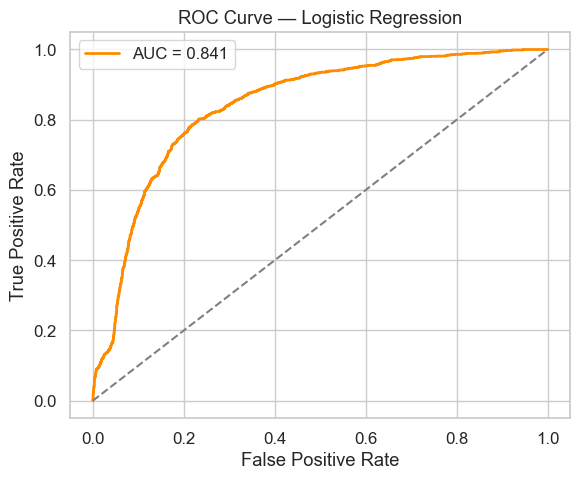

In [11]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Convert Spark predictions to Pandas
pdf = predictions.select("churn_flag", "probability").toPandas()
pdf["prob_churn"] = pdf["probability"].apply(lambda x: float(x[1]))

# Compute ROC
fpr, tpr, _ = roc_curve(pdf["churn_flag"], pdf["prob_churn"])
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], color="gray", linestyle="--")
plt.title("ROC Curve — Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

ROC–AUC = 0.841

means the model can correctly distinguish between churners and non-churners 84.1% of the time — a very strong baseline for behavioral churn prediction.

⸻

💬 How to Interpret Practically

If you randomly select one churned user and one active user:
	•	There’s an 84% chance your model will assign a higher churn probability to the churned user.

This means features like num_sessions, thumbs_up, active_days, etc., are already quite informative — even without advanced models.

In [15]:
data.groupBy("churn_flag").count().show()

+----------+--------+
|churn_flag|   count|
+----------+--------+
|         1| 5382467|
|         0|20876732|
+----------+--------+



/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_38970/1123987577.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df, x="Coefficient", y="Feature", palette="coolwarm")


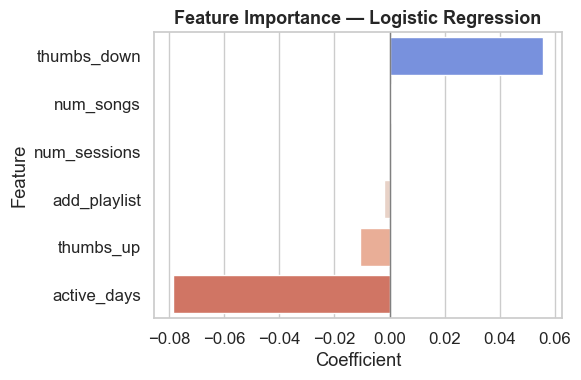

In [10]:
coef_df = pd.DataFrame({
    "Feature": feature_cols,
    "Coefficient": lr_model.stages[-1].coefficients
}).sort_values("Coefficient", ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(data=coef_df, x="Coefficient", y="Feature", palette="coolwarm")
plt.title("Feature Importance — Logistic Regression", fontsize=13, weight="semibold")
plt.axvline(0, color="gray", lw=1)
plt.tight_layout()
plt.show()